In [45]:
from pathlib import Path
import drms
from datetime import datetime
from sunpy.map import Map
import matplotlib.pyplot as plt
import numpy as np
import torch
from magplot.base import create_mesh, mag_plotter

import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

from streamtracer import StreamTracer, VectorGrid

import argparse
from neuralop.models import UNO
from skimage.transform import resize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
b = np.load('/mnt/f/isee_dataset/12673/label/label_12673_20170906_083600.npz')['label']
b = b[:, :-1, :-1, :-1]
b = b.transpose(1, 2, 3, 0)
b.shape

(512, 256, 256, 3)

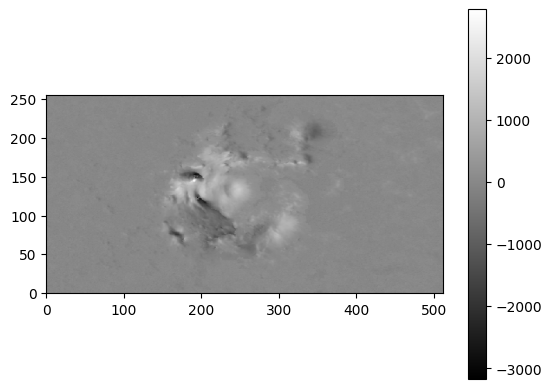

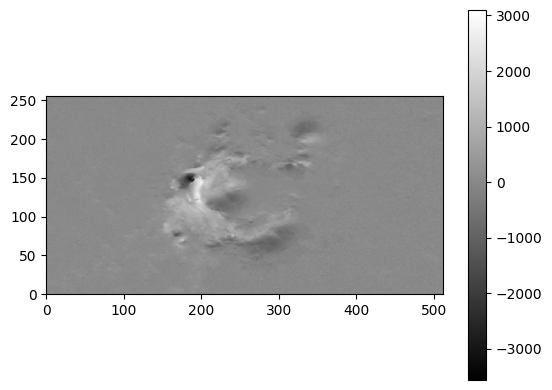

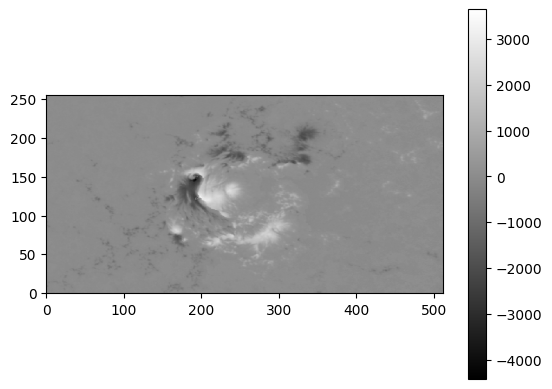

In [47]:
plt.imshow(b[..., 0, 0].T, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(b[..., 0, 1].T, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(b[..., 0, 2].T, origin='lower', cmap='gray')
plt.colorbar()
plt.show()

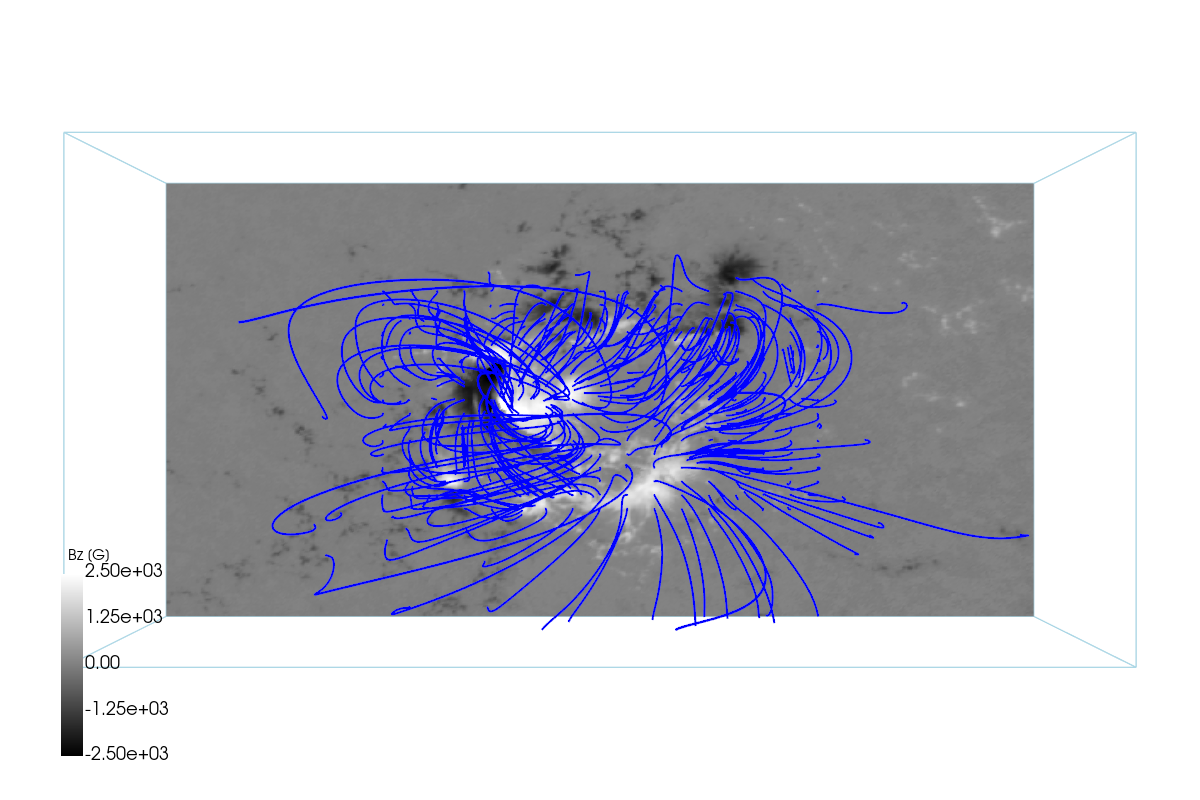

In [48]:
vmin=-2500
vmax=2500
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=16
j_res=16
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

In [49]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

In [50]:
grid_spacing = [1, 1, 1]
grid = VectorGrid(b, grid_spacing)

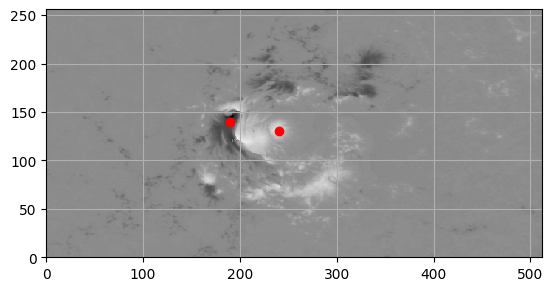

In [51]:
seeds = np.array([[190, 140, 0], 
                  [240, 130, 0]])
plt.pcolor(b[..., 0, 2].T, cmap='gray')
plt.gca().set_aspect('equal')
plt.plot(seeds[:, 0], seeds[:, 1], 'ro')
plt.grid()
plt.show()

In [52]:
tracer.trace(seeds, grid)
print(f'Number of traced lines: {len(tracer.xs)}')
line_lengths = [len(x) for x in tracer.xs]
print(f'Line lengths: {line_lengths}')

Number of traced lines: 2
Line lengths: [840, 2246]


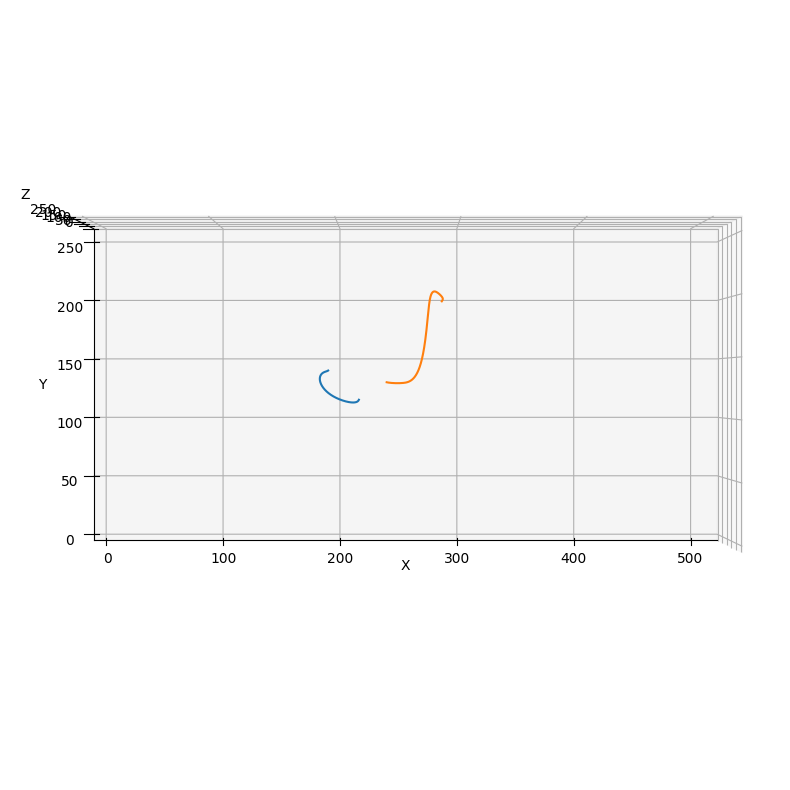

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for xl in tracer.xs:
    ax.plot(xl[:,0], xl[:,1], xl[:,2])
ax.view_init(elev=90, azim=270)
ax.set_xlim(0, 512)
ax.set_ylim(0, 256)
ax.set_zlim(0, 256)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([512,256,256])

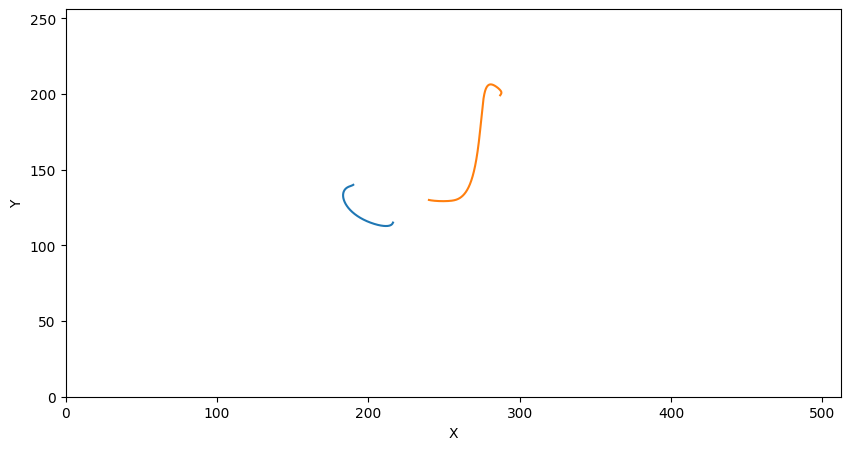

In [54]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for xl in tracer.xs:
    ax.plot(xl[:,0], xl[:,1])
ax.set_xlim(0, 512)
ax.set_ylim(0, 256)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

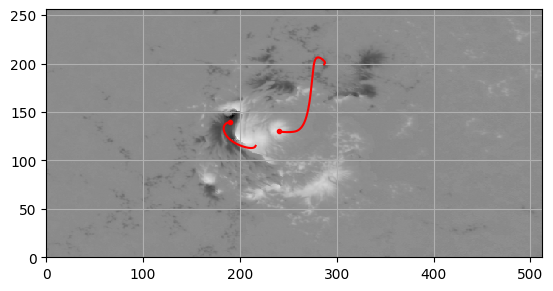

In [55]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

grid_spacing = [1, 1, 1]
grid = VectorGrid(b, grid_spacing)

seeds = np.array([[190, 140, 0], 
                  [240, 130, 0]])
tracer.trace(seeds, grid)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolor(b[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
ax.plot(seeds[:, 0], seeds[:, 1], 'o', color='red', markersize=3)
for xl in tracer.xs:
    ax.plot(xl[:,0], xl[:,1], color='red')
ax.grid()
plt.show()

In [85]:
Lx = 512
Ly = 256
numbers = 20
# numbers = 100
xyranges = [
    # [0.25, 0.75, 0.25, 0.75]
    [0.35, 0.38, 0.50, 0.60],
    # [0.45, 0.50, 0.50, 0.55],
    # [0.35, 0.45, 0.50, 0.55],
    [0.55, 0.60, 0.65, 0.70],
    [0.45, 0.55, 0.65, 0.75],
    [0.58, 0.60, 0.30, 0.35],
    [0.65, 0.70, 0.80, 0.85],
]

nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

grid_spacing = [1, 1, 1]
grid = VectorGrid(b, grid_spacing)

seeds_xs = []
tracer_xs = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    tracer.trace(seeds, grid)
    seeds_xs.append(seeds)
    tracer_xs.append(tracer.xs)

seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]

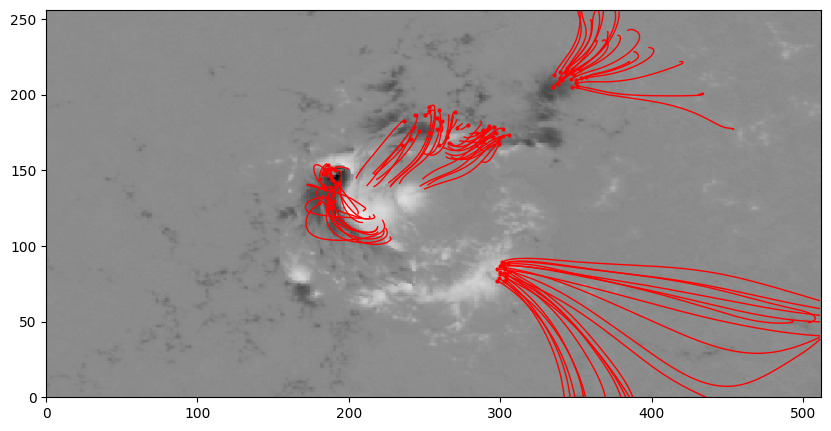

In [86]:
seedcolor = 'red'
seedsize = 2
linecolor = 'red'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

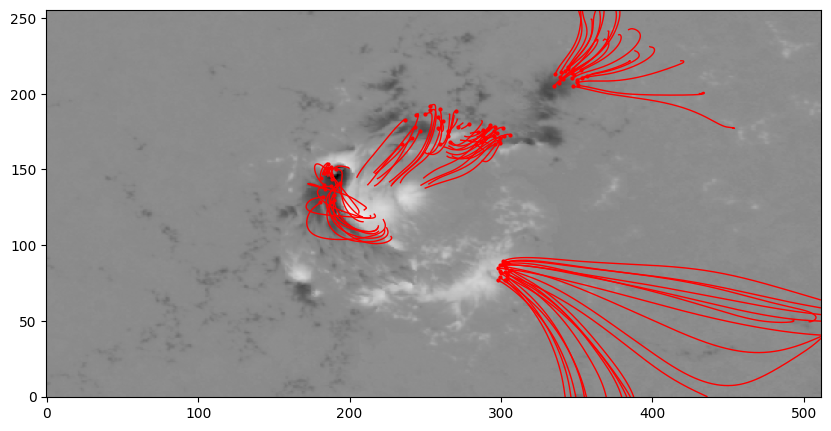

In [87]:
seedcolor = 'red'
seedsize = 2
linecolor = 'red'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(b[..., 0, 2].T, origin='lower', cmap='gray')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

In [88]:
harpnum = 7115
download_dir = Path("download") / str(harpnum)
hmi_Br = Map(str(download_dir / "hmi" / "hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits"))

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]
2024-03-30 20:26:53 - sunpy - WARNING: SunpyMetadataWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.


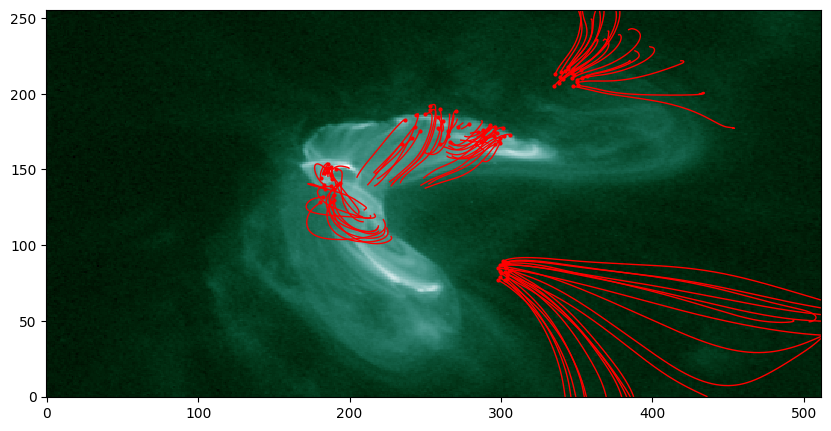

In [89]:
seedcolor = 'red'
seedsize = 2
linecolor = 'red'
linesize = 1

aia_94 = sorted((download_dir / "aia_94").glob("*.fits"))[0]
aia_94 = Map(aia_94)
aia_94 = aia_94.reproject_to(hmi_Br.wcs)
aia_94_data = resize(aia_94.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_94_data, **aia_94.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

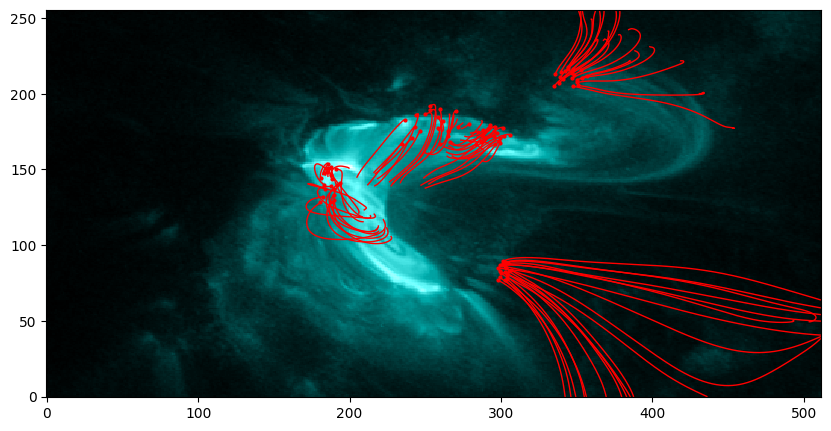

In [90]:
seedcolor = 'red'
seedsize = 2
linecolor = 'red'
linesize = 1

aia_131 = sorted((download_dir / "aia_131").glob("*.fits"))[0]
aia_131 = Map(aia_131)
aia_131 = aia_131.reproject_to(hmi_Br.wcs)
aia_131_data = resize(aia_131.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_131_data, **aia_131.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

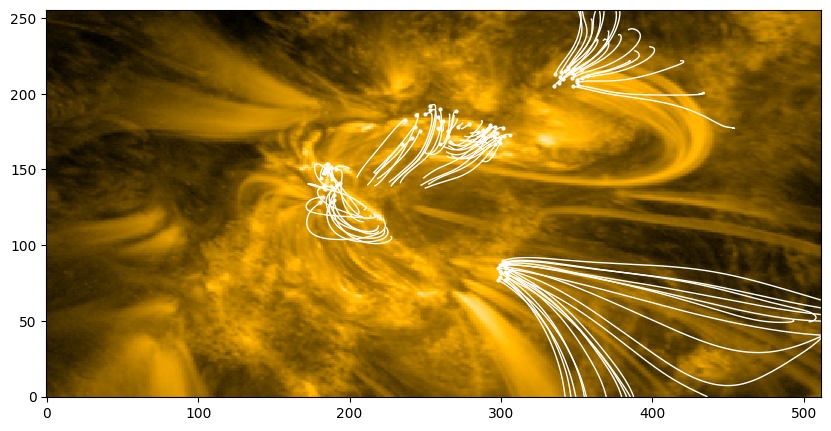

In [91]:
seedcolor = 'white'
seedsize = 2
linecolor = 'white'
linesize = 1

aia_171 = sorted((download_dir / "aia_171").glob("*.fits"))[0]
aia_171 = Map(aia_171)
aia_171 = aia_171.reproject_to(hmi_Br.wcs)
aia_171_data = resize(aia_171.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_171_data, **aia_171.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

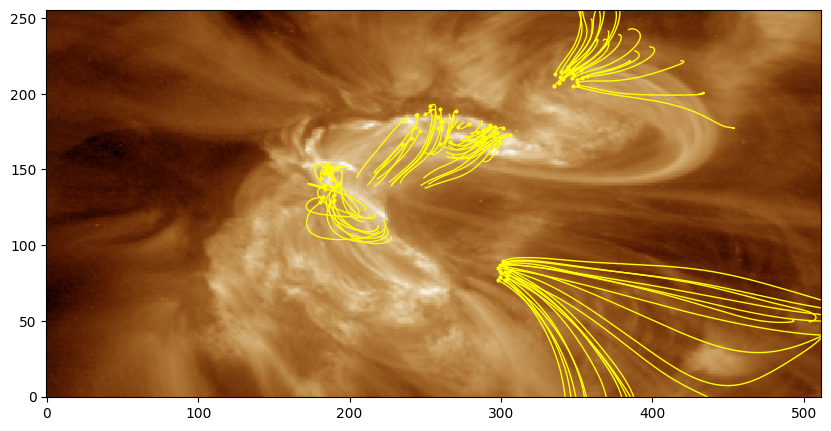

In [92]:
seedcolor = 'yellow'
seedsize = 2
linecolor = 'yellow'
linesize = 1

aia_193 = sorted((download_dir / "aia_193").glob("*.fits"))[0]
aia_193 = Map(aia_193)
aia_193 = aia_193.reproject_to(hmi_Br.wcs)
aia_193_data = resize(aia_193.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_193_data, **aia_193.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

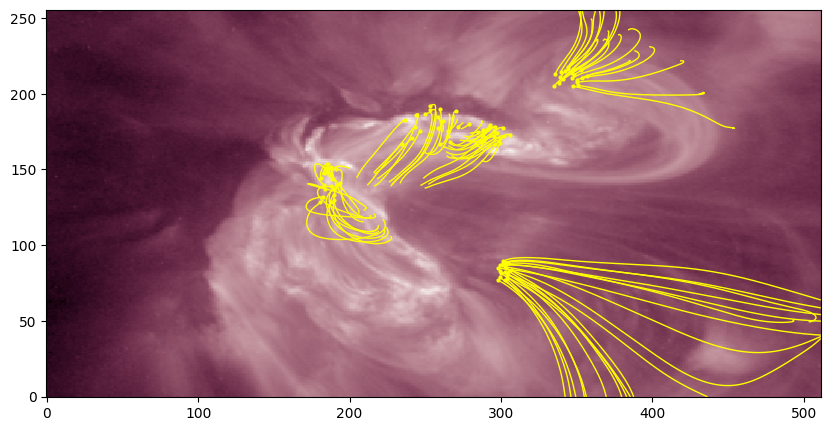

In [93]:
seedcolor = 'yellow'
seedsize = 2
linecolor = 'yellow'
linesize = 1

aia_211 = sorted((download_dir / "aia_211").glob("*.fits"))[0]
aia_211 = Map(aia_211)
aia_211 = aia_211.reproject_to(hmi_Br.wcs)
aia_211_data = resize(aia_211.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_211_data, **aia_211.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

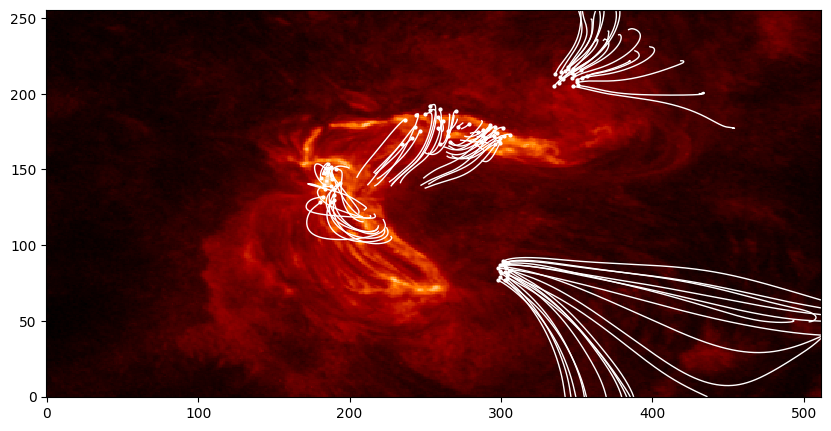

In [94]:
seedcolor = 'white'
seedsize = 2
linecolor = 'white'
linesize = 1

aia_304 = sorted((download_dir / "aia_304").glob("*.fits"))[0]
aia_304 = Map(aia_304)
aia_304 = aia_304.reproject_to(hmi_Br.wcs)
aia_304_data = resize(aia_304.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_304_data, **aia_304.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()

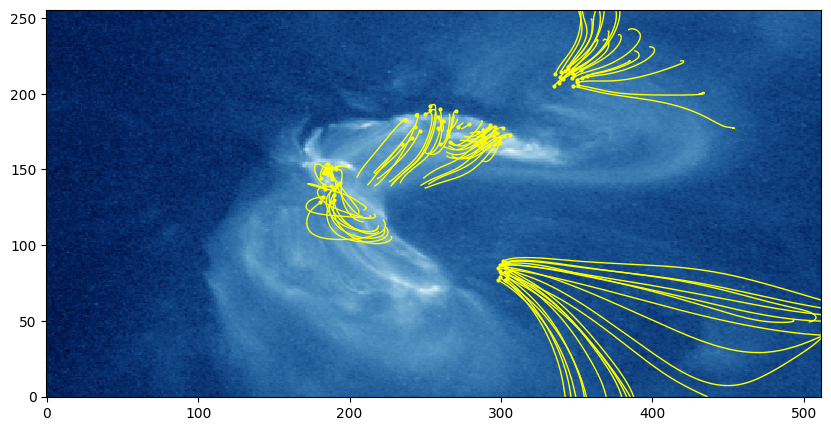

In [95]:
seedcolor = 'yellow'
seedsize = 2
linecolor = 'yellow'
linesize = 1

aia_335 = sorted((download_dir / "aia_335").glob("*.fits"))[0]
aia_335 = Map(aia_335)
aia_335 = aia_335.reproject_to(hmi_Br.wcs)
aia_335_data = resize(aia_335.data, (256, 512))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(aia_335_data, **aia_335.plot_settings)
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.show()